<a href="https://colab.research.google.com/github/james130625/notebook/blob/main/7_S%26P500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 1.1 MB/s eta 0:00:00
HTTP Error 404: Not Found  - symbol "BRKB" not found or invalid periods
Failed to process BRKB: 'Close'
HTTP Error 404: Not Found  - symbol "BFB" not found or invalid periods
Failed to process BFB: 'Close'


Accuracy: 0.9354838709677419
Precision: 0.0
Recall: 0.0


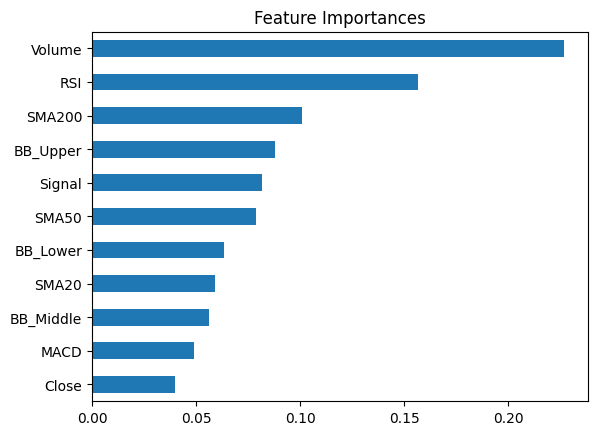

추천된 급등주 종목:
            Code  Close    Volume
Date                             
2024-05-29   WBD   7.66  21184500
2024-04-30  AMCR   8.94  15707400
종목 코드: WBD
실시간 현재가: 8.08
최근 종가: 8.08
52주 최고가: 14.47
52주 최저가: 7.36
52주 중간가: 10.915000000000001
현재 추세: Sell
현재 단계: Sleeping
매수 범위: (7.548163943966578, 8.465836056033421)
1차 매수 목표: 8.007
2차 매수 목표: 8.007
3차 매수 목표: 8.465836056033421
익절가: 15.917000000000002
손절가: 6.992
종목 코드: AMCR
실시간 현재가: 9.88
최근 종가: 9.88
52주 최고가: 10.43
52주 최저가: 8.45
52주 중간가: 9.44
현재 추세: Buy
현재 단계: Eating
매수 범위: (9.685983595467384, 10.537016404532618)
1차 매수 목표: 10.111500000000001
2차 매수 목표: 10.111500000000001
3차 매수 목표: 10.537016404532618
익절가: 11.473
손절가: 8.027499999999998


In [ ]:
# 필요한 패키지 설치
!pip install finance-datareader
!pip install imbalanced-learn

import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
sp500_list = fdr.StockListing('S&P500')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# 기술적 지표 계산 함수
def calculate_technical_indicators(data):
    # 이동 평균 계산
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].rolling(window=200).mean()

    # MACD 계산
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # RSI 계산
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 볼린저 밴드 계산
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=20).std()

    return data

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in sp500_list['Symbol']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 5 and data['Close'].iloc[-1] <= 10:
            data = calculate_technical_indicators(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'SMA20', 'SMA50', 'SMA200', 'MACD', 'Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])

# 상위 10개 종목의 상세 정보 출력
for ticker in top_10_gainers['Code']:
    stock_data = fdr.DataReader(ticker, start_date, end_date)
    stock_data = calculate_technical_indicators(stock_data)

    # 최신 데이터 포인트의 단계 표시
    short_ma = stock_data['SMA20']
    long_ma = stock_data['SMA50']
    current_phase = 'Sleeping'
    if short_ma.iloc[-1] > long_ma.iloc[-1]:
        current_phase = 'Awakening' if short_ma.iloc[-2] <= long_ma.iloc[-2] else 'Eating'

    # 실시간 가격 가져오기 (예시로 최근 종가 사용)
    current_price = stock_data['Close'].iloc[-1]

    # 추가 메트릭 계산
    latest_close = stock_data['Close'].iloc[-1]
    current_trend = "Buy" if stock_data['SMA20'].iloc[-1] > stock_data['SMA50'].iloc[-1] else "Sell"
    fifty_two_week_high = stock_data['Close'].rolling(window=252).max().iloc[-1]
    fifty_two_week_low = stock_data['Close'].rolling(window=252).min().iloc[-1]
    fifty_two_week_mid = (fifty_two_week_high + fifty_two_week_low) / 2

    # 매수 범위와 목표 정의
    buy_range = (stock_data['BB_Lower'].iloc[-1], stock_data['BB_Upper'].iloc[-1])
    first_buy_target = stock_data['SMA20'].iloc[-1]
    second_buy_target = stock_data['BB_Middle'].iloc[-1]
    third_buy_target = stock_data['BB_Upper'].iloc[-1]
    profit_target = fifty_two_week_high * 1.1
    stop_loss = fifty_two_week_low * 0.95

    # 결과 표시
    print(f"종목 코드: {ticker}")
    print("실시간 현재가:", current_price)
    print("최근 종가:", latest_close)
    print("52주 최고가:", fifty_two_week_high)
    print("52주 최저가:", fifty_two_week_low)
    print("52주 중간가:", fifty_two_week_mid)
    print("현재 추세:", current_trend)
    print("현재 단계:", current_phase)
    print("매수 범위:", buy_range)
    print("1차 매수 목표:", first_buy_target)
    print("2차 매수 목표:", second_buy_target)
    print("3차 매수 목표:", third_buy_target)
    print("익절가:", profit_target)
    print("손절가:", stop_loss)
    print("="*50)
